# MMSegmentation for Remote sensing
> a tutorial for using mmsegmentation for land cover classification tasks in remote sensing

- toc: true 
- badges: true
- comments: true
- sticky_rank: 1
- author: Bowen
- categories: [pytorch, mmsegmentation]

In this tutorial, we demo
* How to do inference with MMSeg trained weight
* How to train on your own dataset and visualize the results. 

## Install MMSegmentation
This step may take several minutes. 

We use PyTorch 1.5.0 and CUDA 10.1 for this tutorial. You may install other versions by change the version number in pip install command. 

In [1]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
gcc (Ubuntu 7.5.0-3ubuntu1~16.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
# # Install PyTorch
# !pip install -U torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
# # Install MMCV
# !pip install mmcv-full==latest+torch1.5.0+cu101 -f https://download.openmmlab.com/mmcv/dist/index.html

In [3]:
# !rm -rf mmsegmentation
# !git clone https://github.com/open-mmlab/mmsegmentation.git 
# %cd mmsegmentation
# !pip install -e .

In [4]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

1.7.0 True
0.19.0


## Run Inference with MMSeg trained weight

In [5]:
# !mkdir checkpoints
# !wget https://download.openmmlab.com/mmsegmentation/v0.5/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth -P checkpoints

In [6]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette

In [7]:
config_file = '/home/ubuntu/sharedData/swp/dlLabSwp/favourite/swpFastTest/mmsegmentation/configs/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes.py'
checkpoint_file = 'checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

In [8]:
# build the model from a config file and a checkpoint file
model = init_segmentor(config_file, checkpoint_file, device='cuda:0')

Use load_from_local loader


In [9]:
# test a single image
img = '/home/ubuntu/sharedData/swp/dlLabSwp/favourite/swpFastTest/mmsegmentation/demo/demo.png'
result = inference_segmentor(model, img)

In [10]:
# show the results
show_result_pyplot(model, img, result, get_palette('cityscapes'))

/home/ubuntu/miniconda3/envs/new/lib/python3.8/site-packages/mmseg/models/segmentors/base.py:264: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


## Train a semantic segmentation model on a new dataset

To train on a customized dataset, the following steps are neccessary. 
1. Add a new dataset class. 
2. Create a config file accordingly. 
3. Perform training and evaluation. 

### Add a new dataset

Datasets in MMSegmentation require image and semantic segmentation maps to be placed in folders with the same perfix. To support a new dataset, we may need to modify the original file structure. 

In this tutorial, we give an example of converting the dataset. You may refer to [docs](https://github.com/open-mmlab/mmsegmentation/docs/tutorials/new_dataset.md) for details about dataset reorganization. 

We use [Standord Background Dataset](http://dags.stanford.edu/projects/scenedataset.html) as an example. The dataset contains 715 images chosen from existing public datasets [LabelMe](http://labelme.csail.mit.edu), [MSRC](http://research.microsoft.com/en-us/projects/objectclassrecognition), [PASCAL VOC](http://pascallin.ecs.soton.ac.uk/challenges/VOC) and [Geometric Context](http://www.cs.illinois.edu/homes/dhoiem/). Images from these datasets are mainly outdoor scenes, each containing approximately 320-by-240 pixels. 
In this tutorial, we use the region annotations as labels. There are 8 classes in total, i.e. sky, tree, road, grass, water, building, mountain, and foreground object. 

In [11]:
# download and unzip
# !wget http://dags.stanford.edu/data/iccv09Data.tar.gz -O standford_background.tar.gz
# !tar xf standford_background.tar.gz

### explore the Potsdam dataset

#### overview

<Figure size 576x576 with 0 Axes>

(-0.5, 5999.5, 5999.5, -0.5)

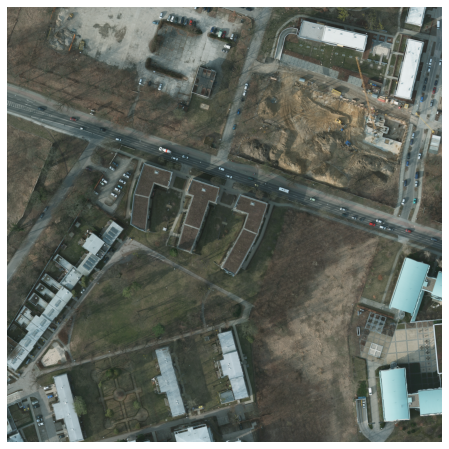

In [12]:
# Let's take a look at the dataset
import mmcv
import matplotlib.pyplot as plt
from fastcore.basics import *
from fastai.vision.all import *
from fastai.torch_basics import *
import warnings
warnings.filterwarnings("ignore")
import kornia
from kornia.constants import Resample
from kornia.color import *
from kornia import augmentation as K
import kornia.augmentation as F
import kornia.augmentation.random_generator as rg
from torchvision.transforms import functional as tvF
from torchvision.transforms import transforms
from torchvision.transforms import PILToTensor

import matplotlib.pyplot as plt
import numpy as np

set_seed(105)
train_a_path = Path("/home/ubuntu/sharedData/swp/dlLab/fastaiRepository/fastai/data/rsData/kaggleOriginal/Potsdam/2_Ortho_RGB/")
label_a_path = Path("/home/ubuntu/sharedData/swp/dlLab/fastaiRepository/fastai/data/rsData/kaggleOriginal/Potsdam/5_labels_for_participants/")
dsm_path = Path("/home/ubuntu/sharedData/swp/dlLab/fastaiRepository/fastai/data/rsData/kaggleOriginal/Potsdam/1_dsm/1_DSM/")
ndsm_path = Path("/home/ubuntu/sharedData/swp/dlLab/fastaiRepository/fastai/data/rsData/kaggleOriginal/Potsdam/1_dsm_normalisation/1_DSM_normalisation/")
imgNames = get_image_files(train_a_path)
lblNames = get_image_files(label_a_path)
dsmNames = get_image_files(dsm_path)
# data
imgNames[0]= Path('/home/ubuntu/sharedData/swp/dlLab/fastaiRepository/fastai/data/rsData/kaggleOriginal/Potsdam/2_Ortho_RGB/top_potsdam_2_11_RGB.tif')
lblNames[0]= Path('/home/ubuntu/sharedData/swp/dlLab/fastaiRepository/fastai/data/rsData/kaggleOriginal/Potsdam/5_labels_for_participants/top_potsdam_2_11_label.tif')
dsmNames[0]=Path('/home/ubuntu/sharedData/swp/dlLab/fastaiRepository/fastai/data/rsData/kaggleOriginal/Potsdam/1_dsm/1_DSM/dsm_potsdam_02_11.tif')

img = mmcv.imread(imgNames[0],channel_order='rgb')
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.show()


In [13]:
torch.cuda.empty_cache()
!nvidia-smi

Sat Nov 20 01:55:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.26       Driver Version: 430.26       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            Off  | 00000000:05:00.0 Off |                  N/A |
| 33%   56C    P2    65W / 250W |   2625MiB / 12194MiB |      2%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            Off  | 00000000:09:00.0 Off |                  N/A |
| 23%   32C    P8     9W / 250W |     10MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

look at the annotations

#### transform between different types

In [14]:
to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()
rgbImage = Image.open(imgNames[0])
lblImage = Image.open(lblNames[0])
dsmImage = Image.open(dsmNames[0])
rgbTensor = image2tensor(rgbImage)
lblTensor = image2tensor(lblImage)
dsmTensor = image2tensor(dsmImage)

In [15]:
type(lblTensor)
rgbTensor.shape
lblTensor.shape
dsmTensor.shape
torch.unique(lblTensor)
lblTensor.shape


torch.Tensor

torch.Size([3, 6000, 6000])

torch.Size([3, 6000, 6000])

torch.Size([1, 6000, 6000])

tensor([  0, 255], dtype=torch.uint8)

torch.Size([3, 6000, 6000])

In [16]:
# pay attention to the dimension, different software package will always leading to different dimensions of the image:
# PIL:(C,H,W)
# SKImage: (H,W,C)
rgbArray = to_np(rgbTensor).transpose(1,2,0)
lblArray = to_np(lblTensor).transpose(1,2,0)
dsmArray = to_np(dsmTensor).transpose(1,2,0)
np.unique(lblArray)


array([  0, 255], dtype=uint8)

 original image is composed of 0 and 255, we need to have a change, turn to the grad scale image with constant values

In [17]:
rgbArray.shape
type(rgbArray)

(6000, 6000, 3)

numpy.ndarray

#### grayscale images

In [18]:
palette = {0 : (255, 255, 255), # Impervious surfaces (white)
           1 : (0, 0, 255),     # Buildings (blue)
           2 : (0, 255, 255),   # Low vegetation (cyan)
           3 : (0, 255, 0),     # Trees (green)
           4 : (255, 255, 0),   # Cars (yellow)
           5 : (255, 0, 0),     # Clutter (red)
           6 : (0, 0, 0)}       # Undefined (black)
invert_palette = {v: k for k, v in palette.items()}


In [19]:
def convert_to_color(arr_2d, palette=palette):
    """ Numeric labels to RGB-color encoding """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

# original label is RGB, we need to have a grayscale label
def convert_from_color(arr_3d, palette=invert_palette):
    """ RGB-color encoding to grayscale labels """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    for c, i in palette.items():
        m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
        arr_2d[m] = i

    return arr_2d

In [20]:
np.unique(convert_from_color(lblArray))

array([0, 1, 2, 3, 4, 5], dtype=uint8)

<AxesSubplot:>

<AxesSubplot:>

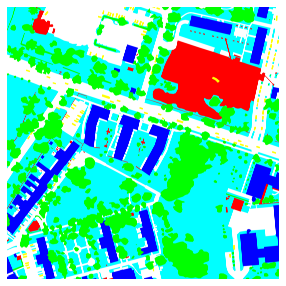

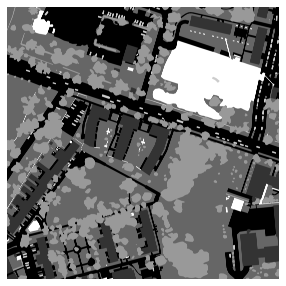

In [21]:
transformedArray  = convert_from_color(lblArray)
show_image(lblImage)
show_image(transformedArray,cmap='gray')


In [22]:
type(transformedArray)

numpy.ndarray

 turn to the array to grayscale image, type is "P"

In [23]:
paletteValue = list(palette.values())
paletteValue

[(255, 255, 255),
 (0, 0, 255),
 (0, 255, 255),
 (0, 255, 0),
 (255, 255, 0),
 (255, 0, 0),
 (0, 0, 0)]

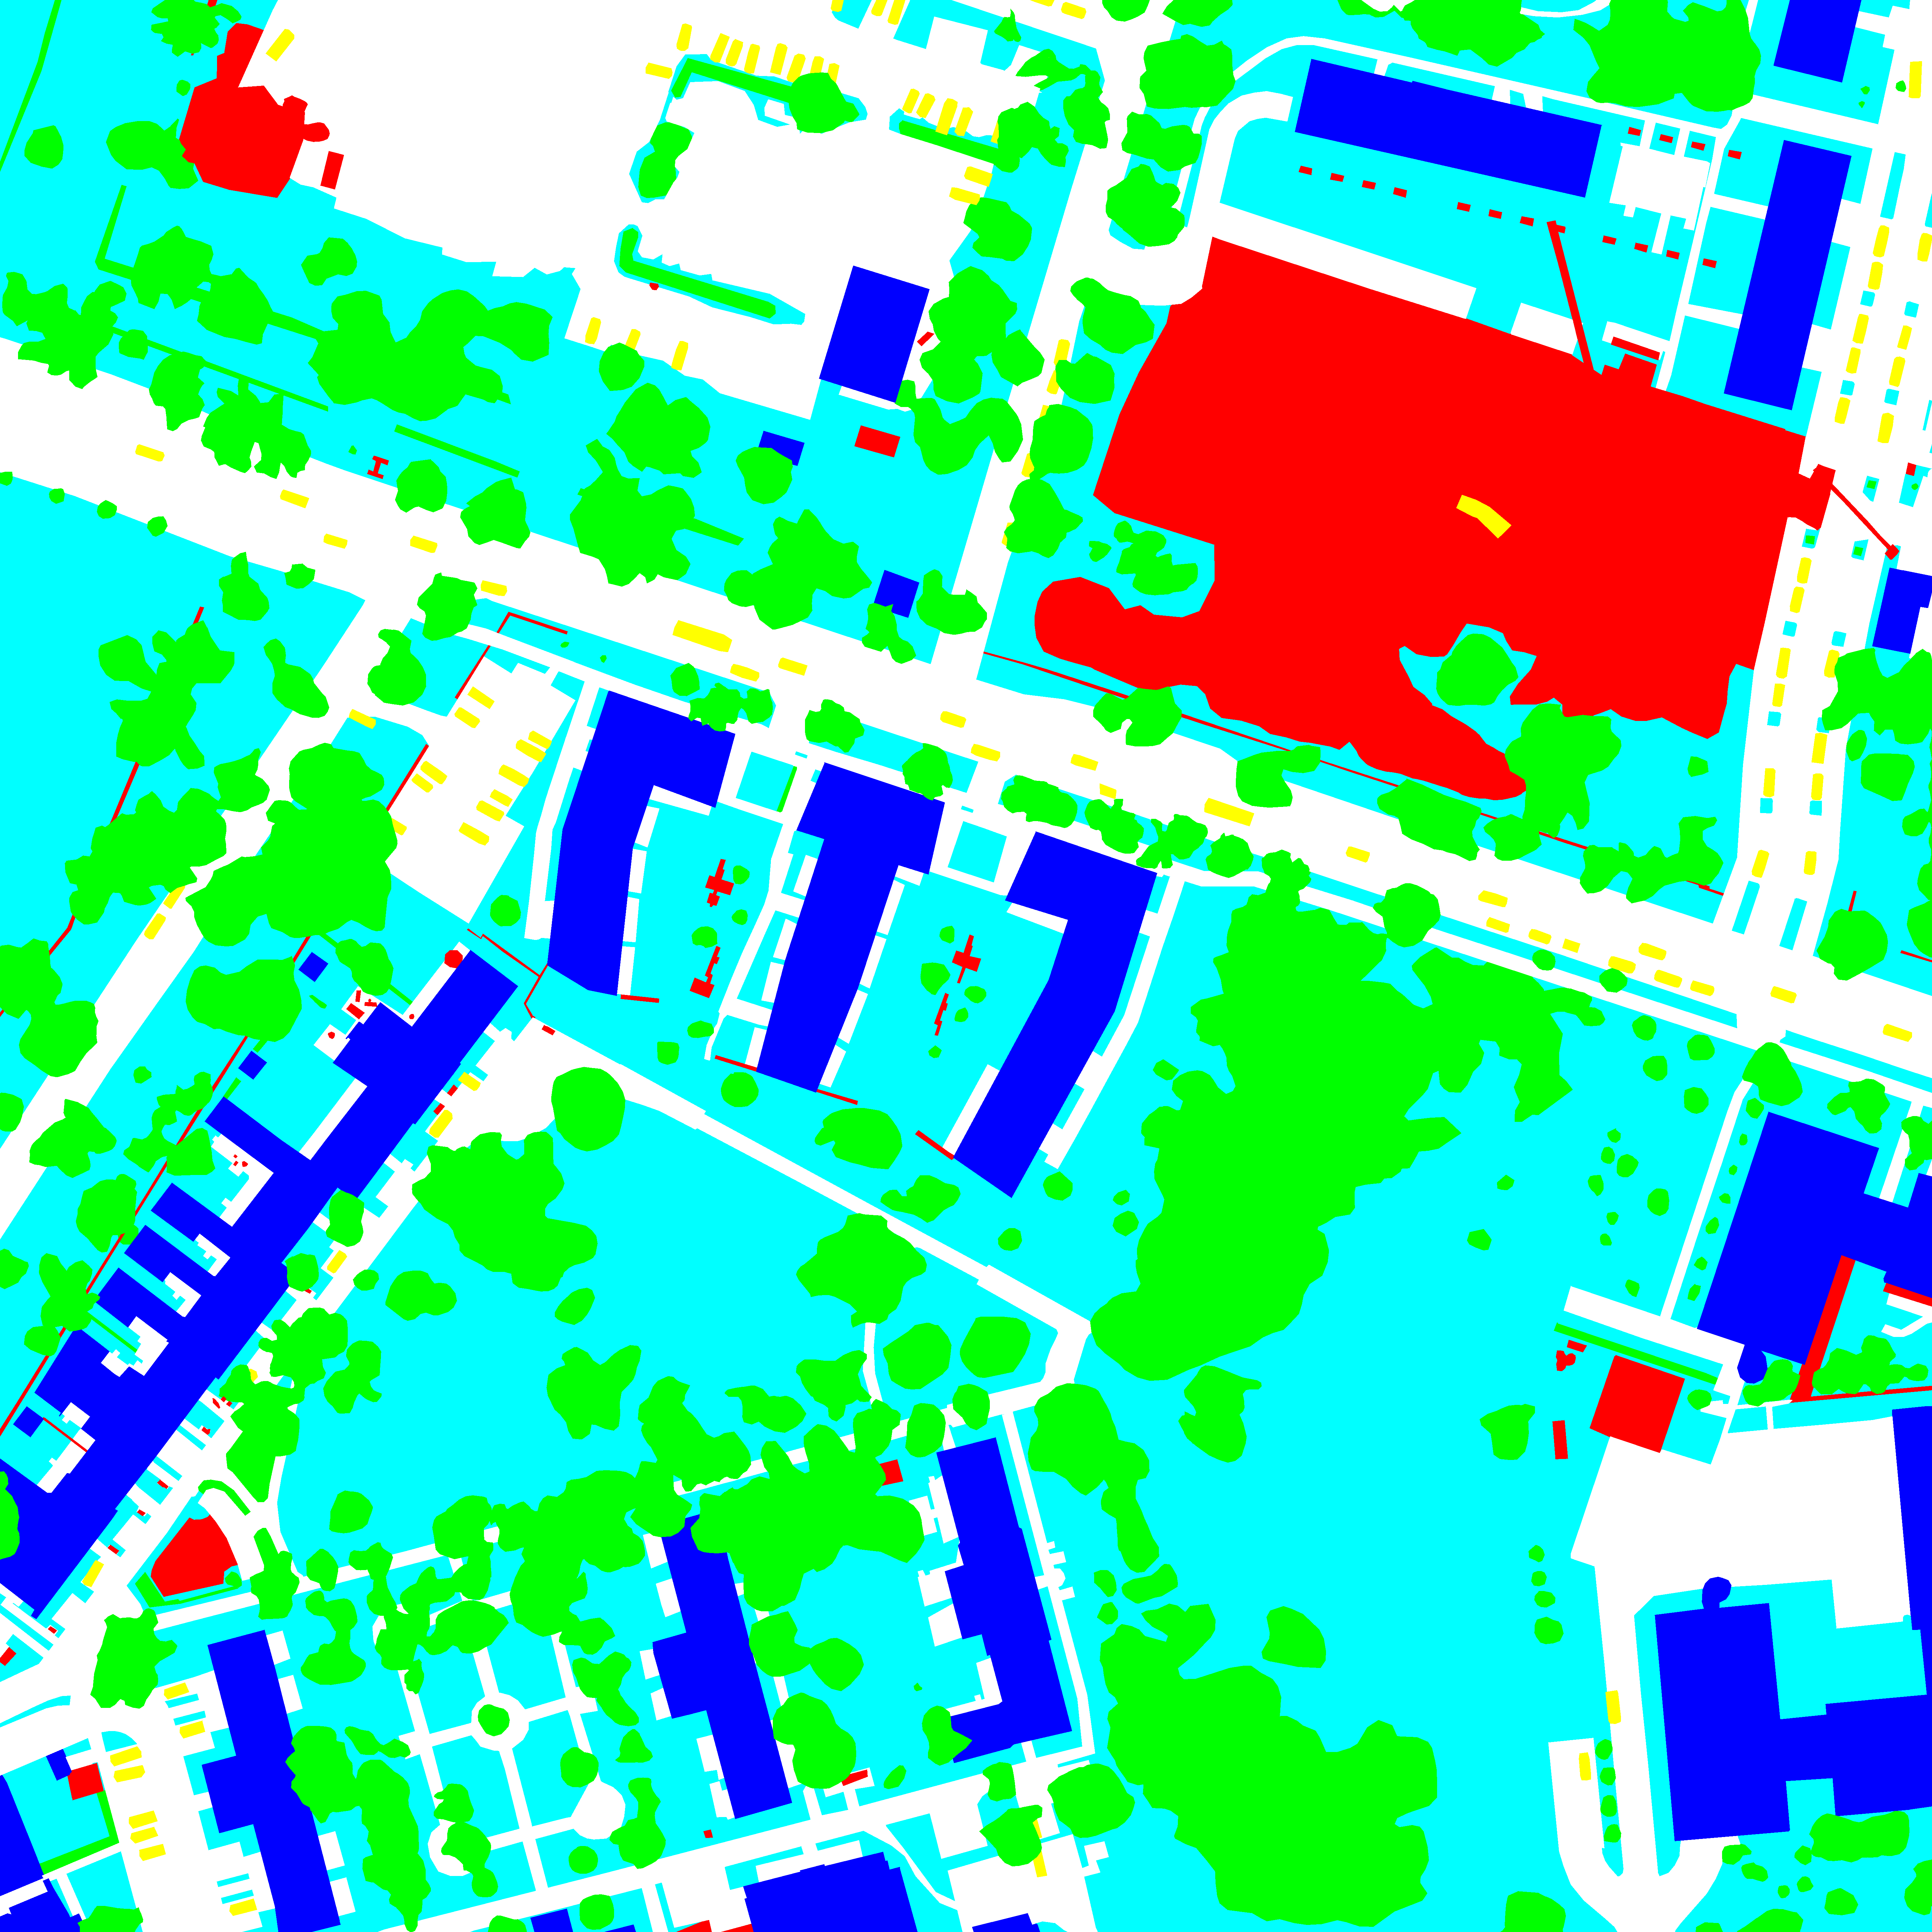

PIL.Image.Image

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [24]:
temp = Image.fromarray(transformedArray).convert('P')
temp.putpalette(np.array(paletteValue, dtype=np.uint8))
# same as the array has shown!
temp
type(temp)
np.unique(temp)

#### transform the whole dataset

In [25]:
paletteValue

[(255, 255, 255),
 (0, 0, 255),
 (0, 255, 255),
 (0, 255, 0),
 (255, 255, 0),
 (255, 0, 0),
 (0, 0, 0)]

In [26]:
len(lblNames)

24

In [27]:
lblNames[0].parent

Path('/home/ubuntu/sharedData/swp/dlLab/fastaiRepository/fastai/data/rsData/kaggleOriginal/Potsdam/5_labels_for_participants')

In [28]:
lblNames[0]

Path('/home/ubuntu/sharedData/swp/dlLab/fastaiRepository/fastai/data/rsData/kaggleOriginal/Potsdam/5_labels_for_participants/top_potsdam_2_11_label.tif')

In [39]:
print(f'label shape using PIL to read is {lblImage.shape}')

label shape using PIL to read is (6000, 6000)


In [40]:
from skimage import io

print(f'label image shape using skimage to read is {io.imread(lblNames[0]).shape}')
# pay attention to these, using io to read an image is different from PIL,
# PIL shape(6000,6000), io shape (6000,6000,3)
temp = np.asarray(convert_from_color(io.imread(lblNames[0])),dtype='int64')
print(f'transformed label shape is {temp.shape}')
print(f'label has {np.unique(temp)} grayscale values')

label image shape using skimage to read is (6000, 6000, 3)
transformed label shape is (6000, 6000)
label has [0 1 2 3 4 5] grayscale values


In [42]:
type(temp)

numpy.ndarray

In [43]:
temp

array([[2, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2]])

In [54]:
temp.shape

(6000, 6000)

In [61]:
convert_to_color(temp).shape

(6000, 6000, 3)

<AxesSubplot:>

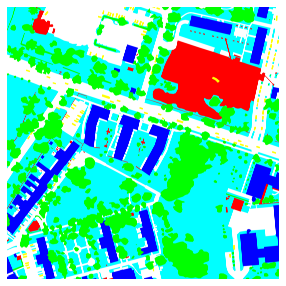

In [57]:
show_image(convert_to_color(temp))

In [50]:
tempImage = Image.fromarray(np.uint8(temp)).convert('P')

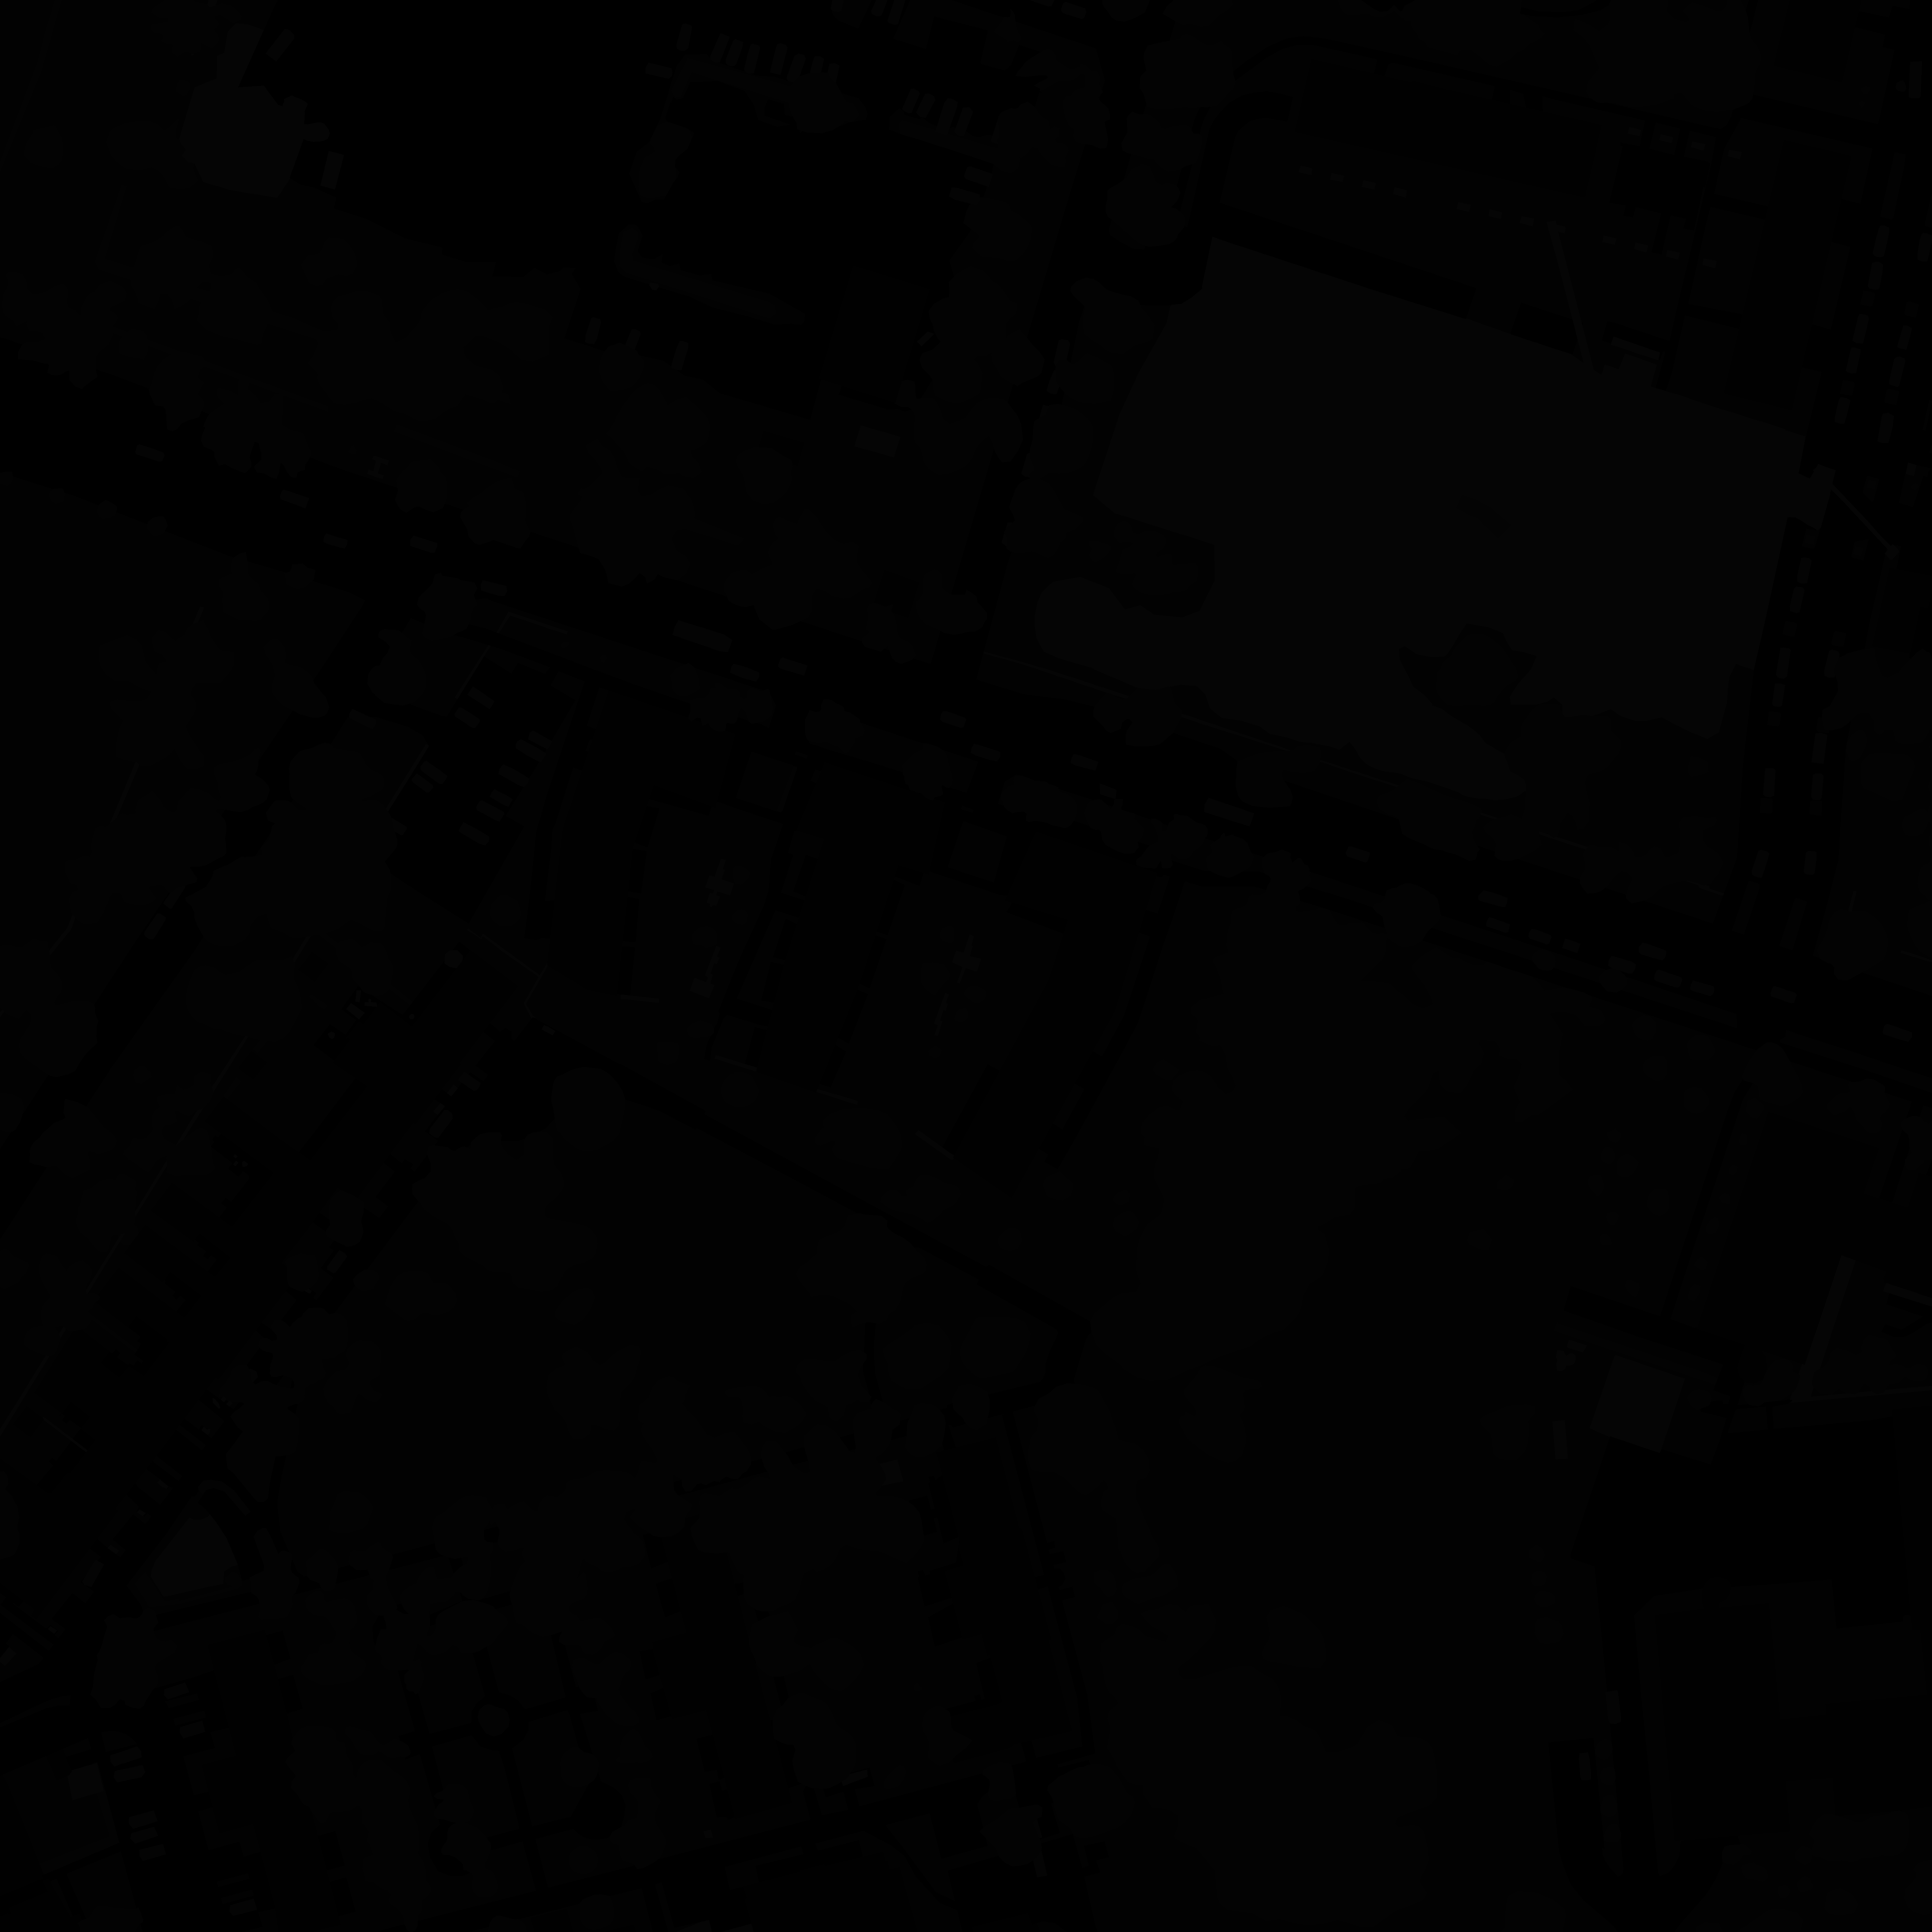

In [51]:
tempImage

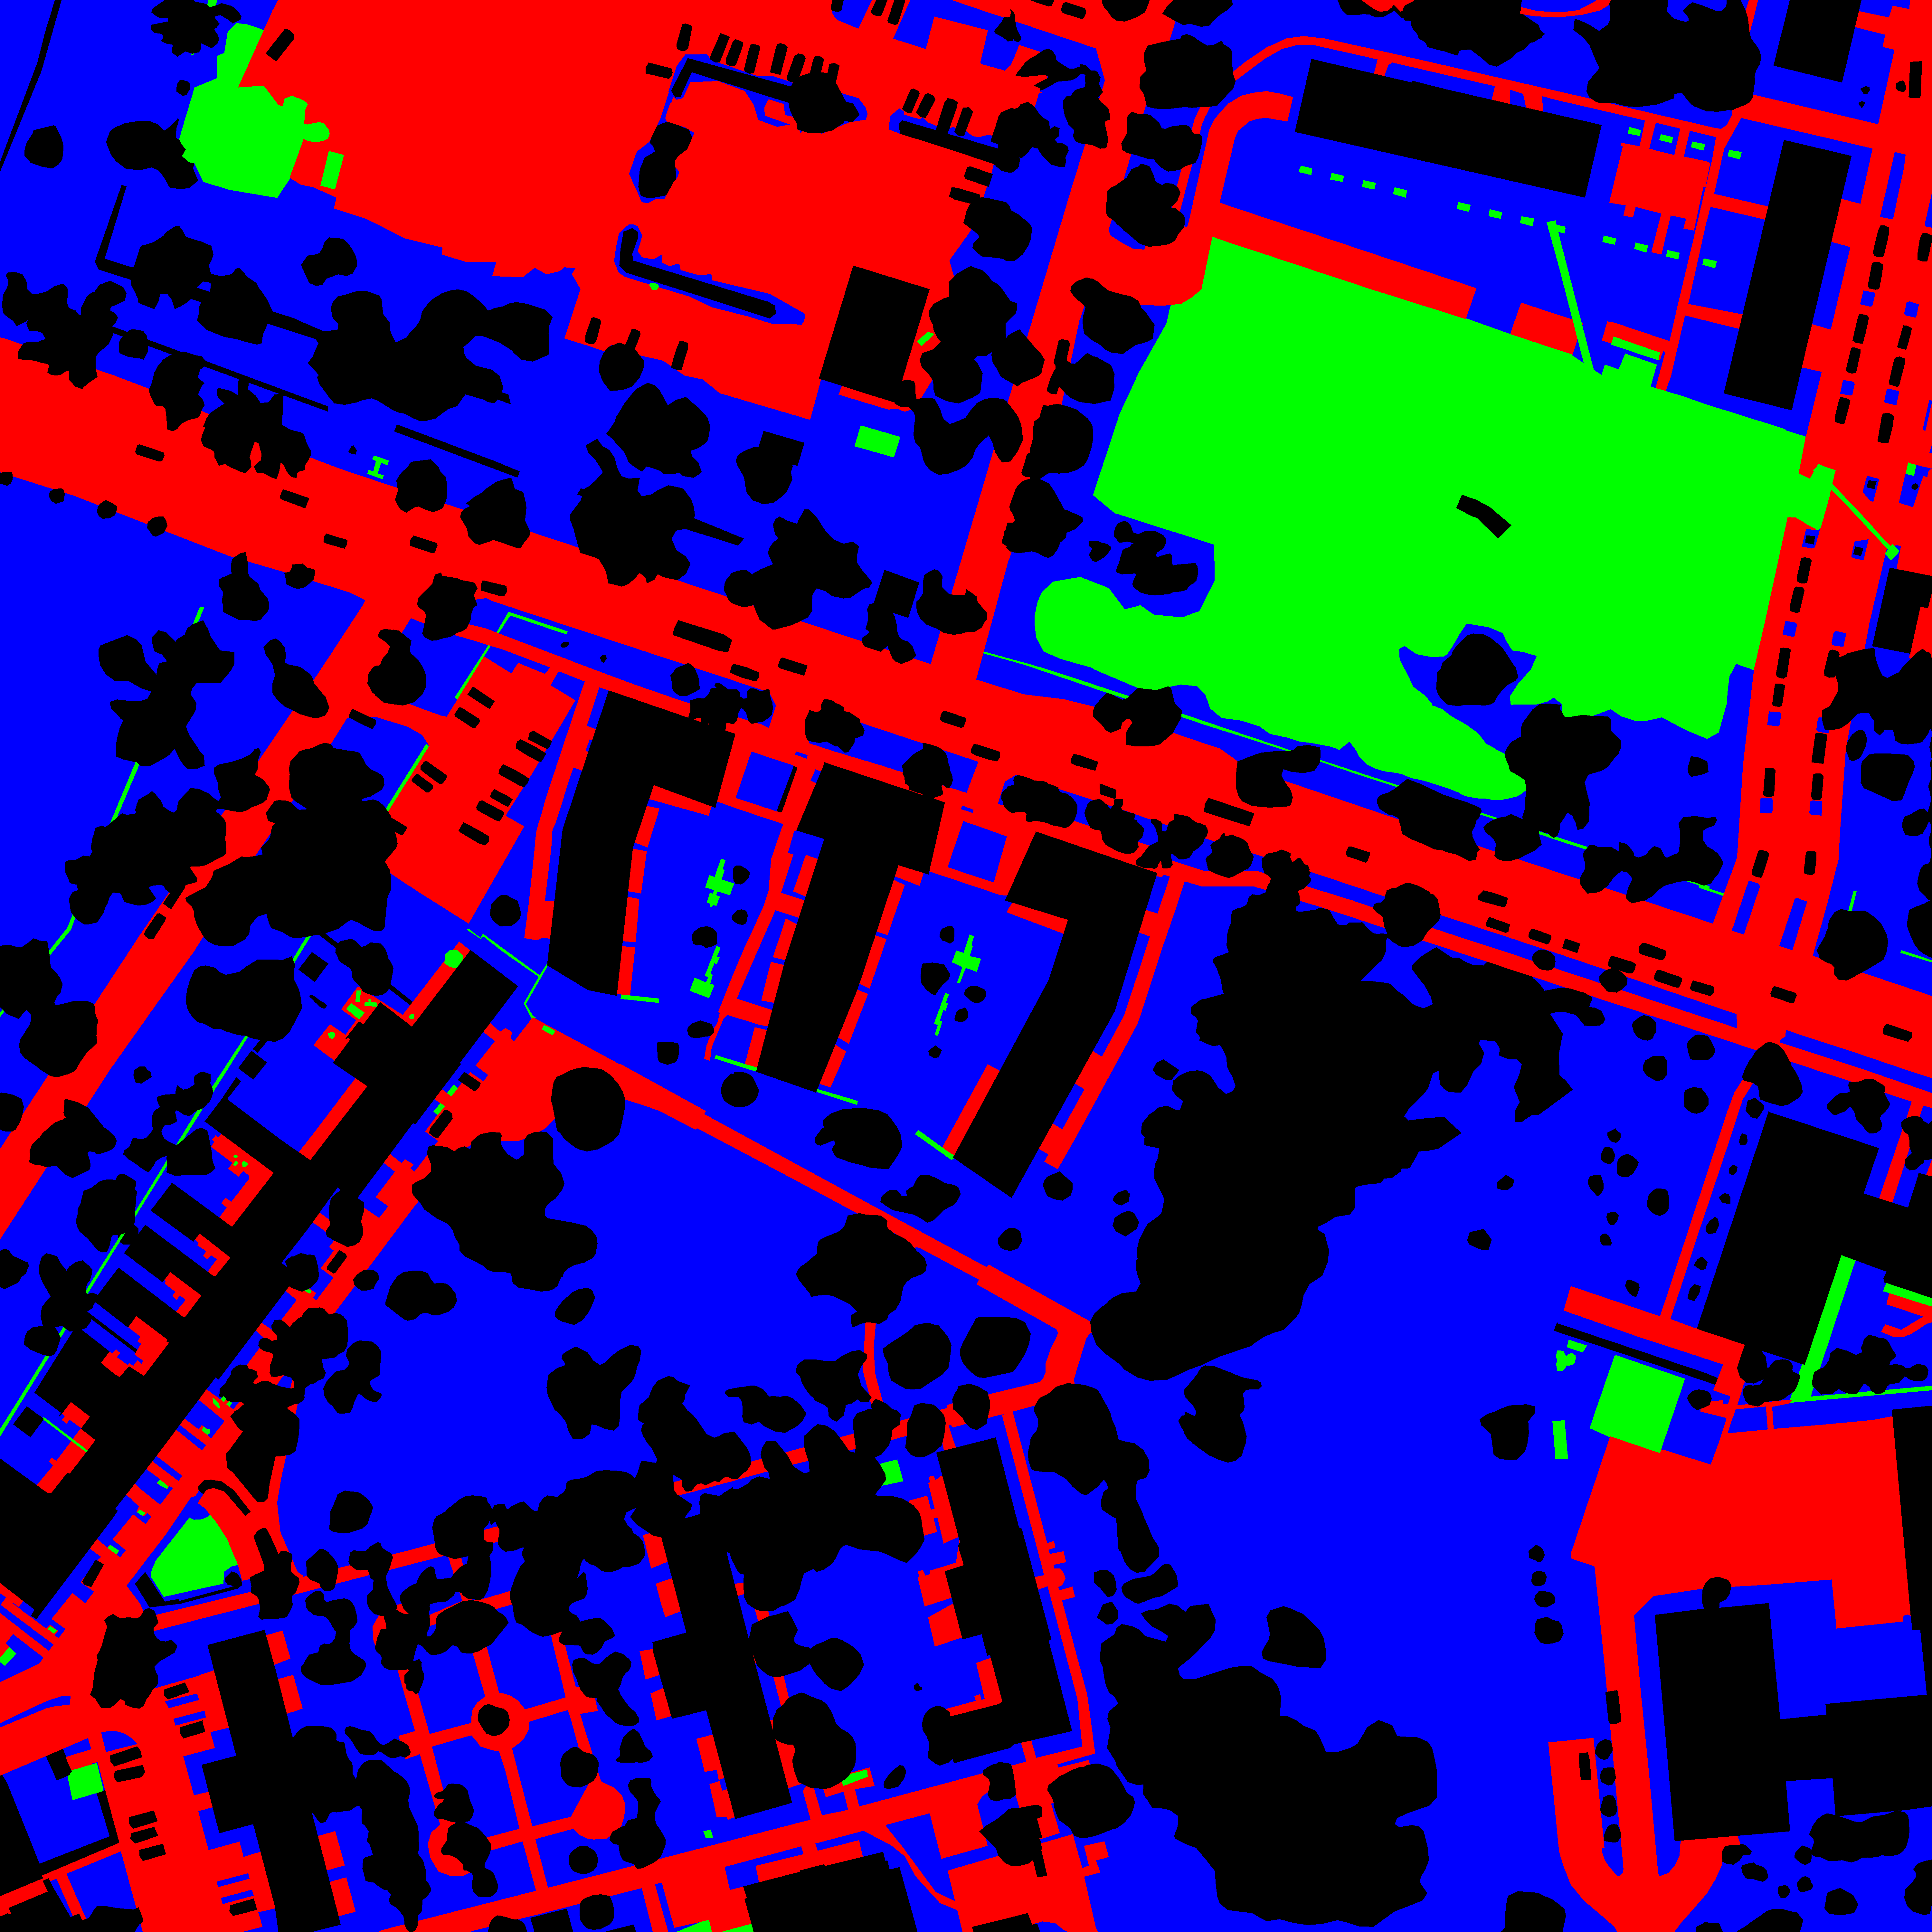

In [60]:
tempImage.putpalette(np.array(paletteValue, dtype='int64'))
tempImage

shapes are different, so this will decide how we will convert the RGB label to the grayscale label

In [43]:
# turn the images in the annotations to grayscale
classes = ['Impervious surface','Buildings','Low vegetation','Trees','Cars','Clutter','Background']
def turnDataset2Gray():
    for index in range(len(lblNames)):
    lblImage = Image.open(lblNames[index])
    lblTensor= image2tensor(lblImage)
    lblArray = to_np(lblTensor).transpose(1,2,0)
    transformedArray  = convert_from_color(lblArray)
    temp = Image.fromarray(transformedArray).convert('P')
    temp.putpalette(np.array(paletteValue, dtype=np.uint8))
    temp.save(lblNames[index].parent/f'{lblNames[index].stem}.tif')
    print(f'{lblNames[index].stem} saved')

# turnDataset2Gray()

top_potsdam_2_11_label saved
top_potsdam_2_10_label saved
top_potsdam_6_8_label saved
top_potsdam_4_11_label saved
top_potsdam_4_12_label saved
top_potsdam_3_10_label saved
top_potsdam_6_11_label saved
top_potsdam_7_11_label saved
top_potsdam_3_11_label saved
top_potsdam_5_10_label saved
top_potsdam_6_9_label saved
top_potsdam_5_11_label saved
top_potsdam_2_12_label saved
top_potsdam_6_12_label saved
top_potsdam_7_9_label saved
top_potsdam_6_10_label saved
top_potsdam_6_7_label saved
top_potsdam_7_8_label saved
top_potsdam_7_10_label saved
top_potsdam_7_12_label saved
top_potsdam_5_12_label saved
top_potsdam_3_12_label saved
top_potsdam_2_11_label saved
top_potsdam_4_10_label saved


In [31]:
import os.path as osp
import numpy as np
from PIL import Image
# convert dataset annotation to semantic segmentation map
data_root = 'iccv09Data'
img_dir = 'images'
ann_dir = 'labels'

In [32]:
osp.join(data_root,ann_dir)

'iccv09Data/labels'

In [47]:
classes

['Impervious surface',
 'Buildings',
 'Low vegetation',
 'Trees',
 'Cars',
 'Clutter',
 'Background']

<Figure size 576x432 with 0 Axes>

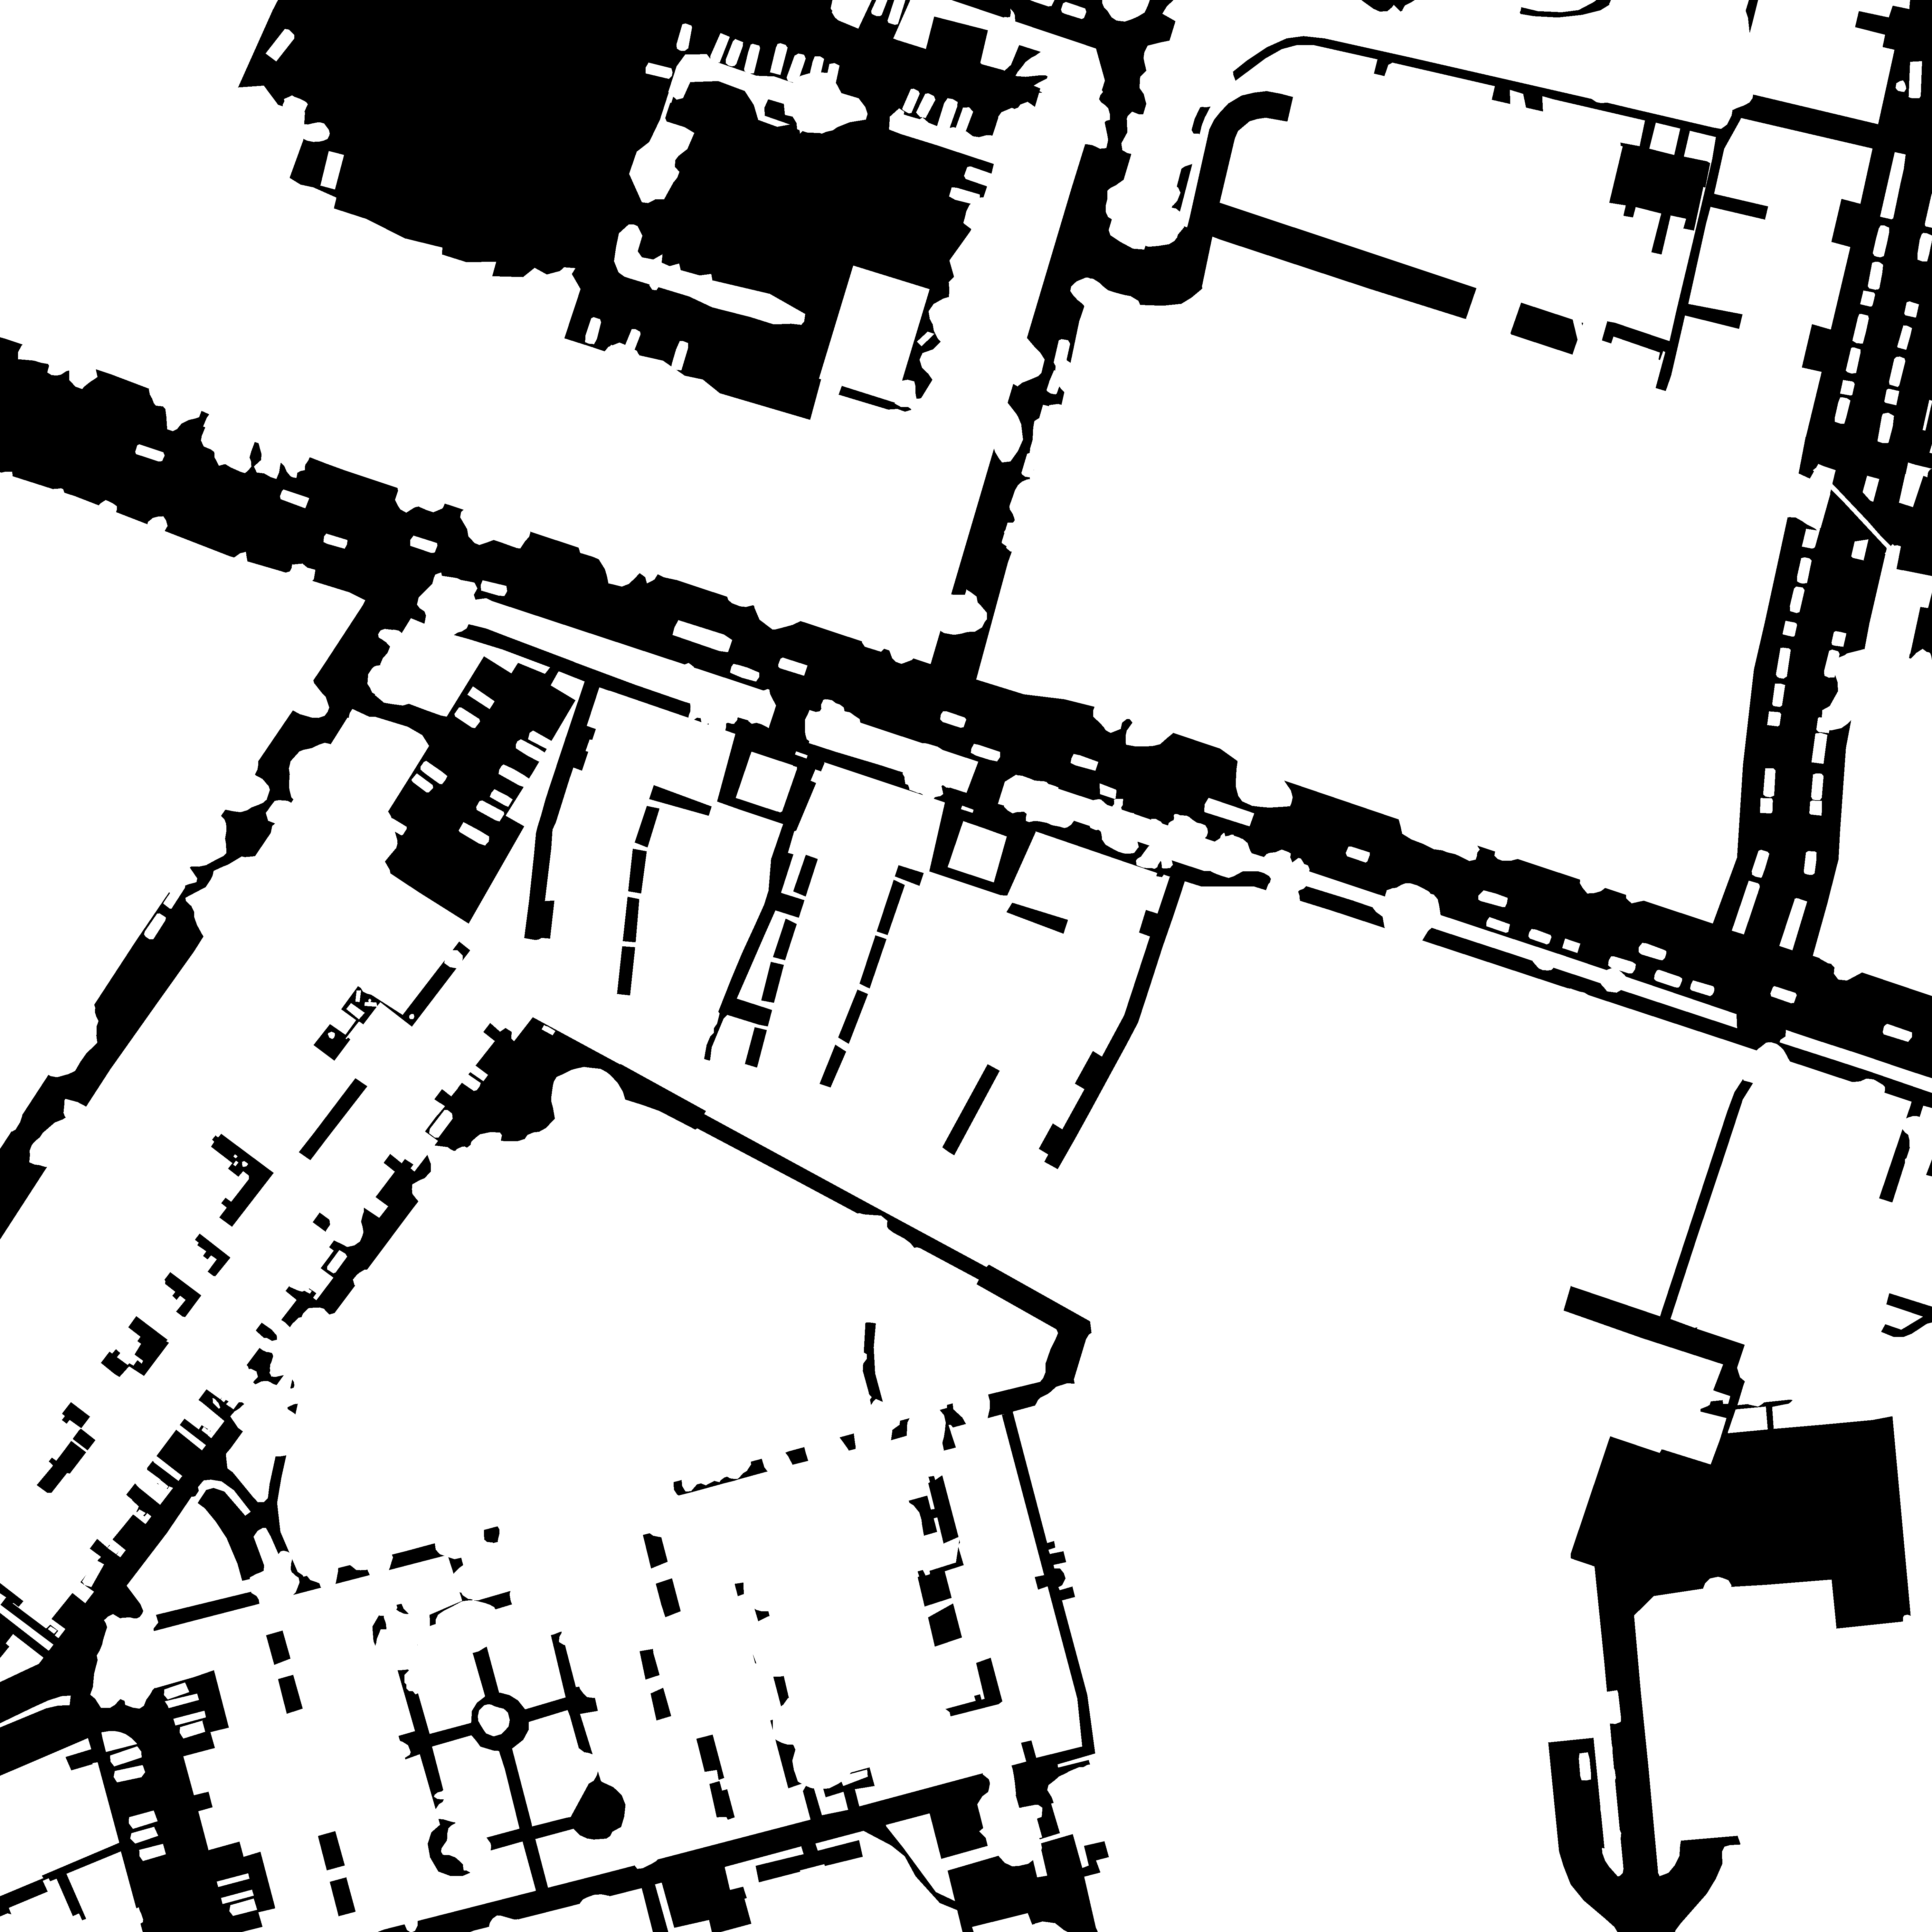

<Figure size 576x432 with 0 Axes>

In [152]:
# Let's take a look at the segmentation map we got
import matplotlib.patches as mpatches
img = Image.open(lblNames[0])
plt.figure(figsize=(8, 6))
img
# im = plt.imshow(convert_to_color(np.array(img)))

In [157]:
img.shape

(6000, 6000)

In [160]:
np.unique(np.array(img))

array([0, 6], dtype=uint8)

In [150]:
np.unique(convert_to_color(np.array(img)))

array([  0, 255], dtype=uint8)

(6000, 6000, 3)

<AxesSubplot:>

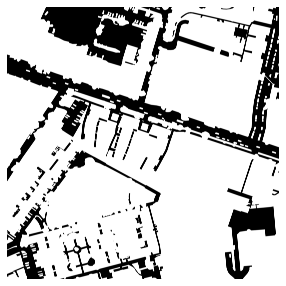

In [151]:
test = convert_to_color(np.array(img))
test.shape
show_image(test)

In [139]:
convert_to_color(np.array(img))

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

<Figure size 576x432 with 0 Axes>

(-0.5, 5999.5, 5999.5, -0.5)

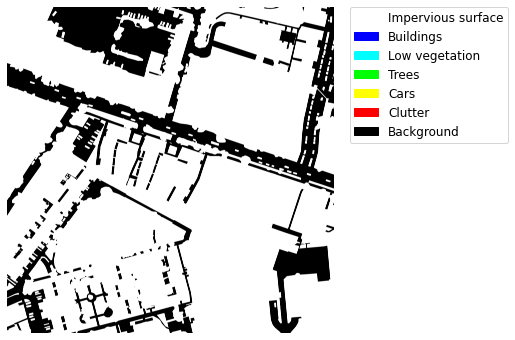

In [49]:
# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(paletteValue[i])/255., 
                          label=classes[i]) for i in range(7)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')
plt.axis('off')
plt.show()

In [21]:
# split train/val set randomly
split_dir = 'splits'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]

In [23]:
len(filename_list)

715

In [24]:
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # select first 4/5 as train set
  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # select last 1/5 as train set
  f.writelines(line + '\n' for line in filename_list[train_length:])

After downloading the data, we need to implement `load_annotations` function in the new dataset class `StandfordBackgroundDataset`.

In [26]:
palette# classes number, 8 in total

[[128, 128, 128],
 [129, 127, 38],
 [120, 69, 125],
 [53, 125, 34],
 [0, 11, 123],
 [118, 20, 12],
 [122, 81, 25],
 [241, 134, 51]]

In [25]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class StandfordBackgroundDataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.jpg', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

    

### Create a config file
In the next step, we need to modify the config for the training. To accelerate the process, we finetune the model from trained weights.

In [28]:
from mmcv import Config
cfg = Config.fromfile('../configs/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes.py')

Since the given config is used to train PSPNet on cityscapes dataset, we need to modify it accordingly for our new dataset.  

In [29]:
from mmseg.apis import set_random_seed

# Since we use ony one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 8
cfg.model.auxiliary_head.num_classes = 8

# Modify dataset type and path
cfg.dataset_type = 'StandfordBackgroundDataset'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu=8

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (256, 256)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(320, 240), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(320, 240),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = 'checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/tutorial'

cfg.runner.max_iters = 200
cfg.log_config.interval = 10
cfg.evaluation.interval = 200
cfg.checkpoint_config.interval = 200

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet50_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='PSPHead',
        in_channels=2048,
        in_index=3,
        channels=512,
        pool_scales=(1, 2, 3, 6),
        dropout_ratio=0.1,
        num_classes=8,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    auxiliary_head=dict(
        type='FCNHead',
        in_channels=1024,
        in_index=2,
        channels=256,
        num_convs=1,
        concat_input=F

### Train and Evaluation

In [30]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor


# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

/home/ubuntu/miniconda3/envs/new/lib/python3.8/site-packages/mmcv/utils/misc.py:323: UserWarning: "flip_ratio" is deprecated in `RandomFlip.__init__`, please use "prob" instead
  warnings.warn(
2021-11-18 03:54:49,540 - mmseg - INFO - Loaded 572 images
/home/ubuntu/miniconda3/envs/new/lib/python3.8/site-packages/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
2021-11-18 03:54:50,369 - mmseg - INFO - Loaded 143 images
2021-11-18 03:54:50,370 - mmseg - INFO - load checkpoint from checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth
2021-11-18 03:54:50,371 - mmseg - INFO - Use load_from_local loader
2021-11-18 03:54:50,504 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 512, 1, 1]) from checkpoint, the s

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 27.1 task/s, elapsed: 5s, ETA:     0s

2021-11-18 03:57:43,412 - mmseg - INFO - per class results:
2021-11-18 03:57:43,414 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
|  sky   |  88.8 | 93.79 |
|  tree  | 72.41 | 84.84 |
|  road  | 87.26 | 92.57 |
| grass  | 74.83 |  90.8 |
| water  | 69.31 | 87.65 |
|  bldg  | 79.14 | 87.31 |
|  mntn  | 26.12 | 29.31 |
| fg obj | 67.55 |  81.0 |
+--------+-------+-------+
2021-11-18 03:57:43,414 - mmseg - INFO - Summary:
2021-11-18 03:57:43,416 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.22 | 70.68 | 80.91 |
+-------+-------+-------+
2021-11-18 03:57:43,417 - mmseg - INFO - Iter(val) [143]	aAcc: 0.8822, mIoU: 0.7068, mAcc: 0.8091, IoU.sky: 0.8880, IoU.tree: 0.7241, IoU.road: 0.8726, IoU.grass: 0.7483, IoU.water: 0.6931, IoU.bldg: 0.7914, IoU.mntn: 0.2612, IoU.fg obj: 0.6755, Acc.sky: 0.9379, Acc.tree: 0.8484, Acc.road: 0.9257, Acc.grass: 0.9080, Acc.water: 0.8765, Acc.bldg: 0.873

Inference with trained model

<Figure size 576x432 with 0 Axes>

/home/ubuntu/miniconda3/envs/new/lib/python3.8/site-packages/mmseg/models/segmentors/base.py:264: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

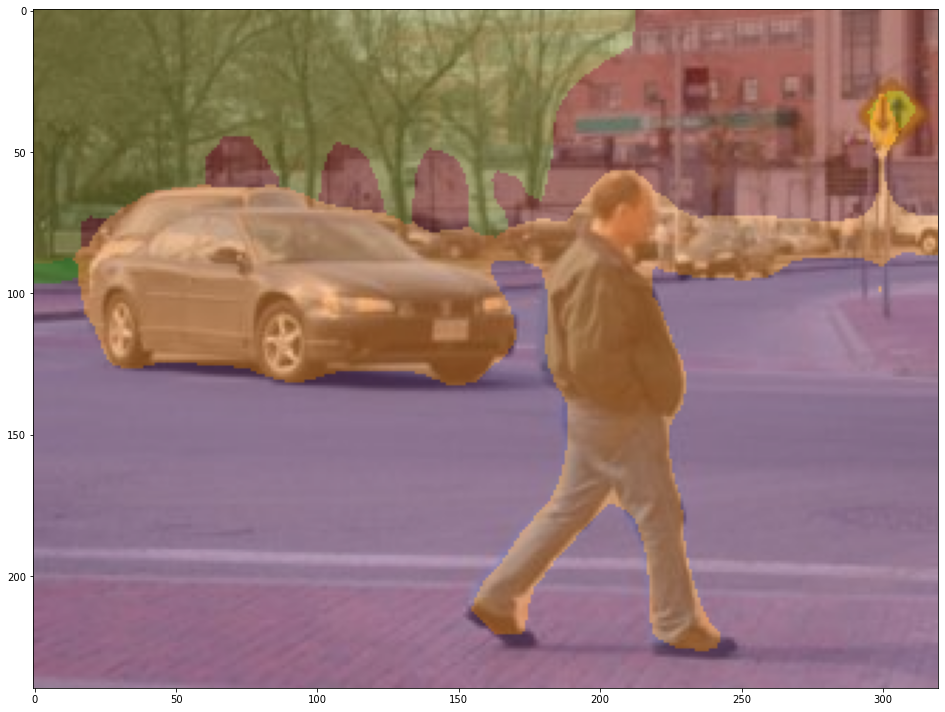

In [31]:
img = mmcv.imread('iccv09Data/images/6000124.jpg')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)